# Исследование штаммов коронавируса.

## 1. Введение.

В интернете существует популярная конспирологическая теория о том, что нынешняя эпидемия коронавируса `COVID-19` (в научной терминологии `SARS-CoV-2`) - дело человеческих рук. Причина: первые вспышки этого вируса зарегистрированы в городе Ухани, где расположен Институт вирусологии, как раз занимавшийся исследованием коронавируса и создававший некоторые его гибридные формы. Поэтому распространилось мнение, что коронавирус является специально созданным биологическим оружием! Постараемся проверить этот миф.

### Гипотеза.

**Гипотеза**: `SARS-CoV-2` - это вирус, созданный искусственно и затем мутировавший. Предположительно - сбежавший (или выпущенный) из лаборатории Института вирусологии Уханя вирус `SHC014-MA15`, который был там создан путем замены гена, кодирующего шиповидный белок вируса `SARS Coronavirus MA15`, на аналогичный ген из `RsSHC014-COV`.

### Цель.

В данном исследовании я постараюсь опровергнуть эту гипотезу, доказав, что, по всей видимости, `COVID-19` имеет естесственное происхождение, мутировав из видов, паразитирующих на летучих мышах. В качестве основы исследования я возьму [статью Александра Панчина](https://vk.com/scinquisitor?w=wall187756_253565), самостоятельно проведя упомянутые в ней эксперименты и дополнив собственными.

### Методика исследования.

Основными методами данного исследования будет сравнение различных штаммов коронавируса: как полных геномов, так и их подпоследовательностей. Это позволит оценивать степень родства и схожесть геномов, находить участки генома, по которым штаммы различаются сильнее всего, а также построить филогенетическое дерево. Исследование я буду проводить на языке $R$, главным образом оперируя с нуклеотидными последовательностями в формате `DNAbin` и `AAbin`.

### Материалы.

Используемые данные загружены с сайта [NCBI](https://www.ncbi.nlm.nih.gov/genbank/sars-cov-2-seqs/#nucleotide-sequences) в формате `fasta`. Я буду исследовать как полные геномы (в формате `DNAbin`), так и отдельные протеины (в формате `AAbin`). Для построения филогенетического дерева все загруженные геномы (несколько десятков) собраны в один файл `common.fasta`; помимо этого, некоторым участкам генома определенных штаммов будет уделено особенное внимание, поэтому они записаны в отдельные файлы.

## 2. План исследования.

* Подробно сравним следующие четыре штамма: `SARS Coronavirus MA15` (штамм JF292920), `RaTG13` (эти два взяты у летучих мышей в 2014 и 2013 годах соответственно), `RsSHC014-COV`(его носителями также являются летучие мыши) и современный `COVID-19` (я рассмотрел штамм `MT019529`, один из самых ранних найденных в Ухани в декабре 2019 г.). Отсюда узнаем и степень их сходства с лабораторно созданным `SHC014-MA15` (полученный заменой гена, кодирующего шиповидный белок вируса `SARS Coronavirus MA15`, на аналогичный ген из `RsSHC014-COV`.)

* Исследуем их сходство на основе полных геномов, а также, повторяя эксперименты А. Панчина, полипротеина `1ab` и шиповидного белка (последний особенно важен, учитывая природу создания `SHC014-MA15`).

* На основе этого продемонстрируем, что современный коронавирус по строению генома гораздо ближе к `RaTG13`, чем к остальным двум видам. Это позволит отвергнуть гипотезу о его происхождении `SHC014-MA15`, а если к тому же сходство с `RaTG13` окажется большим, показать, что он, вероятно, мутировал от вирусов летучих мышей и вряд ли вообще имеет какое-либо искусственное происхождение.

* Построим также филогенетическое дерево по геномам большого числа различных штаммов, включая выше упомянутые четыре. Это, предположительно, позволит продемонстрировать большое сходство всех штаммов современного коронавируса из разных стран и дополнительно подтвердит полученные ранее выводы.

* Исследуем, какие участки генетического кода у штаммов менялись чаще всего и визуализируем эти данные.

## 3. Демонстрация работы основных методов исследования в языке R на небольших искусственных примерах.

In [2]:
library("igraph")
library("ggtree")
library("phangorn")
library("treeio")
library("Biostrings")
library("msa")
library("ape")
library("insect")
library("ggseqlogo")
library("ggplot2")

### 3.1. Выравнивание нуклеотидных последовательностей.

Для сравнения участков генома разных штаммов необходимо, чтобы они были одинаковой длины. При этом и участки, отвечающие за конкретный белок, и полные геномы совершенно необязательно будут иметь одну длину. Нужен инструмент, который позволит выровнять набор нуклеотидные последовательностей, дополнив их (знаками пропуска) до одной длины, причем так, чтобы положение соответствующих участков совпадало. В языке **R** это можно сделать с помощью следующего кода:


```python
fasta_data <- read.fasta("common.fasta")
l <- c(dna2char(fasta_data[1]))
for (i in 2:16) {
    l <- rbind(l, c(dna2char(fasta_data[i])))
}
# Привели формат DNAbin (набор ДНК-последовательностей) 
# к списку из этих последовательностей в формате dna2char
string.set <- DNAStringSet(l)
string.set <- msa(string.set)
fasta_data <- as.DNAbin(string.set)
```

Демонстрация работы на маленьких данных:

In [3]:
Q1 <- as.DNAbin(c("T","C","C","G","A","A","T","A","A","G","T","A","A","A"))
Q2 <- as.DNAbin(c("C","C","G","A","A","T","C","A","G","T","A"))
Q3 <- as.DNAbin(c("T","C","T","A","A","A","T","A","A","G","C","A","C"))
Q4 <- as.DNAbin(c("T","T","T","A","A","T","A","A","G","C","A","C"))
Q5 <- as.DNAbin(c("G","T","T","A","A","T","A","A","G","A","C"))
l <- c(dna2char(Q1),dna2char(Q2),dna2char(Q3),dna2char(Q4),dna2char(Q5))
string.set <- DNAStringSet(l)
string.set <- msa(string.set)
print(string.set)
small.dnabin <- as.DNAbin(string.set)
print(small.dnabin)

use default substitution matrix
CLUSTAL 2.1  

Call:
   msa(string.set)

MsaDNAMultipleAlignment with 5 rows and 14 columns
    aln 
[1] -TTTAATAAGCAC-
[2] -GTTAATAAG-AC-
[3] TCTAAATAAGCAC-
[4] TCCGAATAAGTAAA
[5] -CCGAATCAGTA--
Con -CT?AATAAG?AC- 
5 DNA sequences in binary format stored in a matrix.

All sequences of same length: 14 

Labels:

Base composition:
    a     c     g     t 
0.443 0.180 0.131 0.246 
(Total: 70 bases)


Как видим, выравнивание корректно сработало, общие части последовательностей идут точно друг над другом.

Однако для выравнивания нескольких десятков последовательностей длины порядка $30000$ нуклеотидов у меня не достаточно вычислительной мощности (это займет слишком много времени), поэтому для получения того же результата воспользуемся онлайн-ресурсом [Clustal Omega](https://www.ebi.ac.uk/Tools/msa/clustalo/). Полученный в результате файл с выровненными ДНК-последовательностями назовем `common_msa.fasta`.

### 3.2. Филогенетическое дерево (игрушечный пример).

Теперь построим филогенетического дерево по небольшому количеству маленьких ДНК-последовательностей одной длины, полученных в предыдущем пункте.

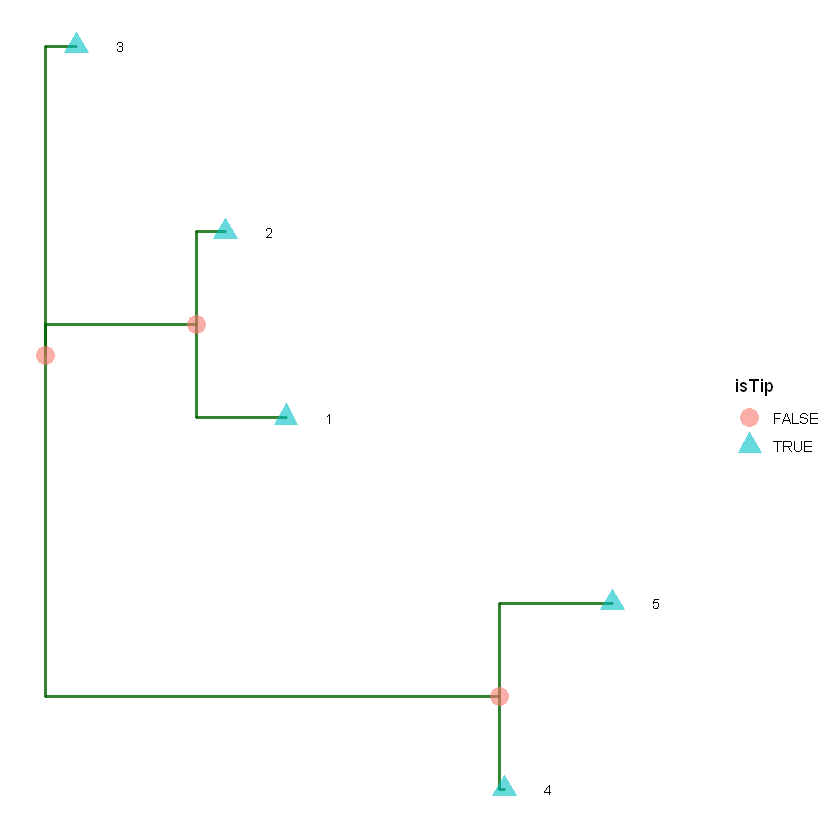

In [4]:
phy.data <- as.phyDat(as.matrix(small.dnabin))
tree <- nj(dist.ml(phy.data))
ggtree(tree, lwd = 1, color = "darkgreen", alpha = 0.8, right = TRUE) +
  geom_tiplab(size = 3, angle = 0, offset = 0.05, hjust = 3) +
  geom_point(aes(shape = isTip, color = isTip), size = 5, alpha = 0.6)

### 3.3 Простая функция сравнения DNA- и AA- последовательностей.

Реализуем функцию, позволяюшую сравнивать поэлементно нуклеотидные последовательности одной длины и возвращающую сходство в виде числа от $0$ до $1$.

In [14]:
element_wise.compare <- function(seq1,seq2){
    mean(strsplit(as.character(seq1),"")[[1]] == 
       strsplit(as.character(seq2),"")[[1]])
}

In [6]:
Q1 <- dna2char(as.DNAbin(c("T","C","C","G","A","A","T","A","A","G","T","A","A","A")))
Q2 <- dna2char(as.DNAbin(c("-","C","C","G","A","A","T","C","A","G","T","A","-","-")))
element_wise.compare(Q1, Q2)

[1] 0.7142857

### 3.4 Сравнение последовательностей с визуализацией (игрушечный пример).

В исследовании будем сравнивать короткие последовательности с помощью `ggseqlogo`, а длинные -  с помощью `stacked barplot`. Кроме того, для визуализации сходства последовательностей будем строить простую матрицу с помощью стандартной функции `image` (в отличие от `stacked barplot`, эта матрица явно показывает нуклеотид в каждой позиции для каждой последовательности, а не частоту нуклеотидов в этой позиции). Продемонстрируем построение всех трех из этих видов графиков.

##### 3.4.1. ggseqlogo.

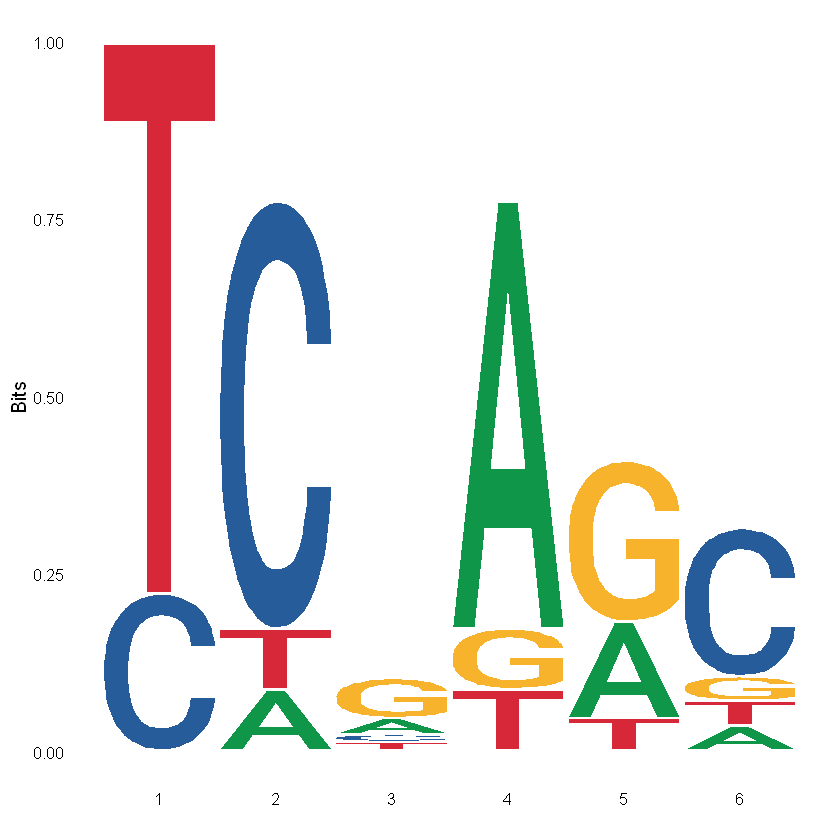

In [5]:
Q1 <- as.DNAbin(c("T","T","C","G","A","C"))
Q2 <- as.DNAbin(c("C","C","G","A","A","C"))
Q3 <- as.DNAbin(c("T","C","G","A","A","T"))
Q4 <- as.DNAbin(c("T","C","T","A","G","G"))
Q5 <- as.DNAbin(c("T","A","G","A","T","A"))
Q6 <- as.DNAbin(c("T","C","G","A","G","C"))
Q7 <- as.DNAbin(c("C","C","A","A","G","C"))
Q8 <- as.DNAbin(c("T","C","G","T","G","C"))
Q9 <- as.DNAbin(c("T","C","A","A","G","C"))
l <- c(dna2char(Q1),dna2char(Q2),dna2char(Q3),
      dna2char(Q4),dna2char(Q5),dna2char(Q6),
      dna2char(Q7),dna2char(Q8),dna2char(Q9))

ggseqlogo(l)

##### 3.4.2. Матрица из нуклеотидов для визуального сравнения последовательностей.

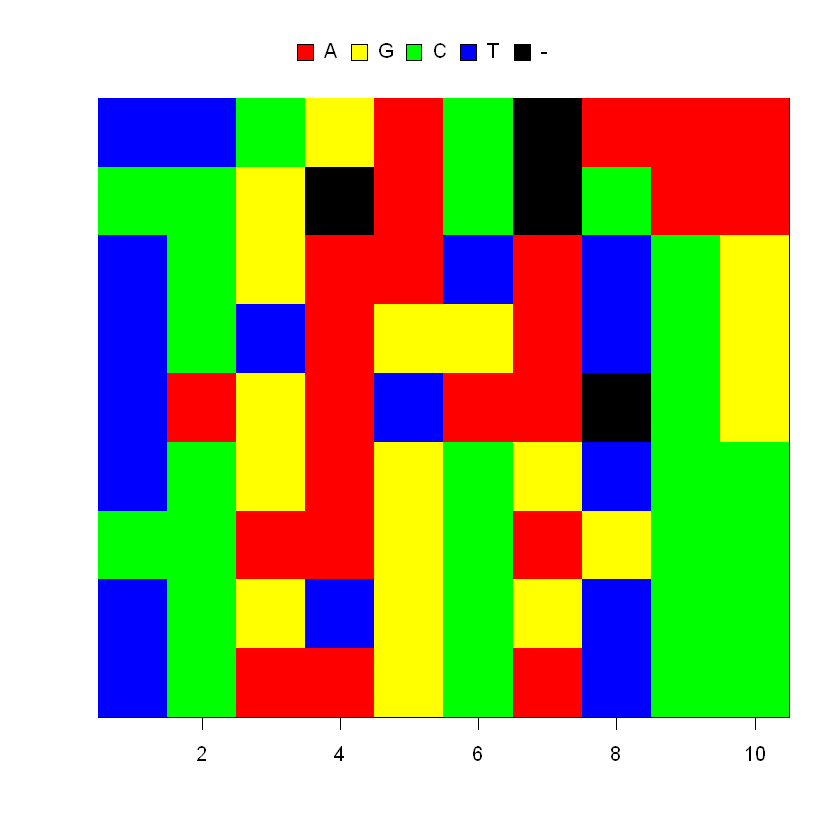

In [188]:
Q1 <- as.DNAbin(c("T","T","C","G","A","C","-","A","A","A"))
Q2 <- as.DNAbin(c("C","C","G","-","A","C","-","C","A","A"))
Q3 <- as.DNAbin(c("T","C","G","A","A","T","A","T","C","G"))
Q4 <- as.DNAbin(c("T","C","T","A","G","G","A","T","C","G"))
Q5 <- as.DNAbin(c("T","A","G","A","T","A","A","-","C","G"))
Q6 <- as.DNAbin(c("T","C","G","A","G","C","G","T","C","C"))
Q7 <- as.DNAbin(c("C","C","A","A","G","C","A","G","C","C"))
Q8 <- as.DNAbin(c("T","C","G","T","G","C","G","T","C","C"))
Q9 <- as.DNAbin(c("T","C","A","A","G","C","A","T","C","C"))
l <- c(dna2char(Q1),dna2char(Q2),dna2char(Q3),
      dna2char(Q4),dna2char(Q5),dna2char(Q6),
      dna2char(Q7),dna2char(Q8),dna2char(Q9))
image(as.DNAbin(DNAStringSet(l)))

##### 3.4.3. stacked barplot.

Реализуем функцию, принимающую `AAStringSet` и рисующую по ней `stacked barplot`.

In [210]:
Q1 <- as.DNAbin(c("T","T","C","G","A","C","-","A","A","A"))
Q2 <- as.DNAbin(c("C","C","G","-","A","C","-","C","A","A"))
Q3 <- as.DNAbin(c("T","C","G","A","A","T","A","T","C","G"))
Q4 <- as.DNAbin(c("T","C","T","A","G","G","A","T","C","G"))
Q5 <- as.DNAbin(c("T","A","G","A","T","A","A","-","C","G"))
Q6 <- as.DNAbin(c("T","C","G","A","G","C","G","T","C","C"))
Q7 <- as.DNAbin(c("C","C","A","A","G","C","A","G","C","C"))
Q8 <- as.DNAbin(c("T","C","G","T","G","C","G","T","C","C"))
Q9 <- as.DNAbin(c("T","C","A","A","G","C","A","T","C","C"))
l <- c(dna2char(Q1),dna2char(Q2),dna2char(Q3),
      dna2char(Q4),dna2char(Q5),dna2char(Q6),
      dna2char(Q7),dna2char(Q8),dna2char(Q9))

In [211]:
stacked.barplot <- function(dna.string.set){
    seq.length <- width(dna.string.set)[1]
    # Длина последовательностей
    seq.count <- length(dna.string.set)
    # Кол-во последовательностей
    freq <- (consensusMatrix(dna.string.set)[1:4,])/seq.count
    dim(freq) <- c(1,4*seq.length)
    freq <- as.numeric(freq)
    # Частота
    
    position <- t(as.matrix(rep(1:seq.length,4)))
    dim(position) <- c(seq.length,4)
    position <- t(position)
    dim(position) <- c(4*seq.length,1)
    position <- as.integer(t(position))
    
    nucleotide <- rep(c("A","C","G","T"),seq.length)
    df <- data.frame(position,nucleotide,freq)
    ggplot(df, aes(fill=nucleotide, y=freq, x=position)) + 
    geom_bar(position="stack", stat="identity")
}

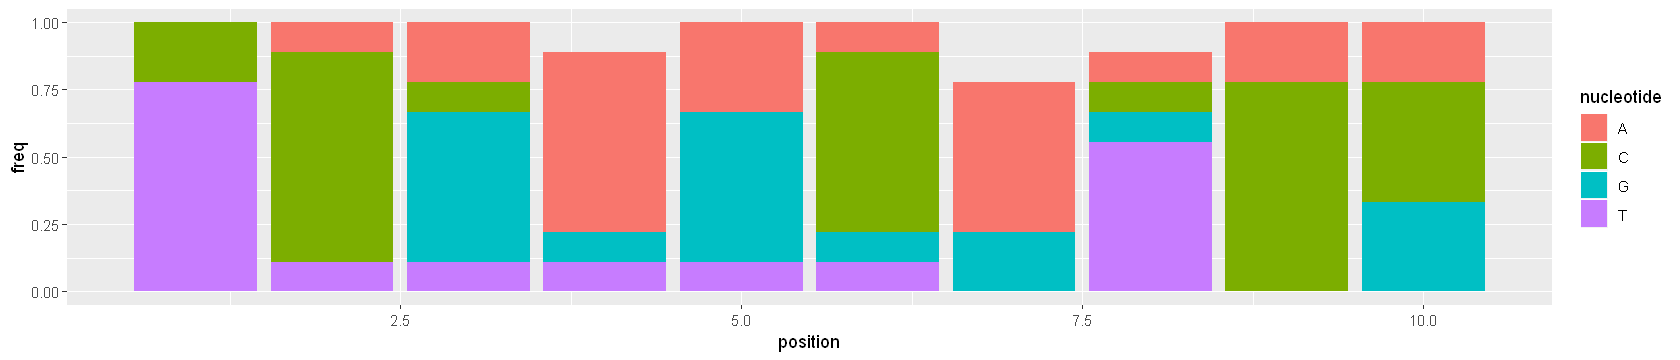

In [214]:
options(repr.plot.width=14, repr.plot.height=3)
stacked.barplot(DNAStringSet(l))

## 4. Основное исследование. Сравнение COVID-19, MA15, RaTG13 и RsSHC014-COV.

#### 4.1 Визуальное сравнение штаммов коронавируса (stacked barplot)

Построим `stacked barplot` по $55$ различным предварительно выровненным штаммам (подробный их перечень напечатан ниже, в разделе $4.5$ с филогенетическим деревом), которые мы будем исследовать далее. Из них $49$ штаммов относятся к `COVID-19`, остальные - штаммы `MA15`, `RaTG13`, `RsSHC014`.

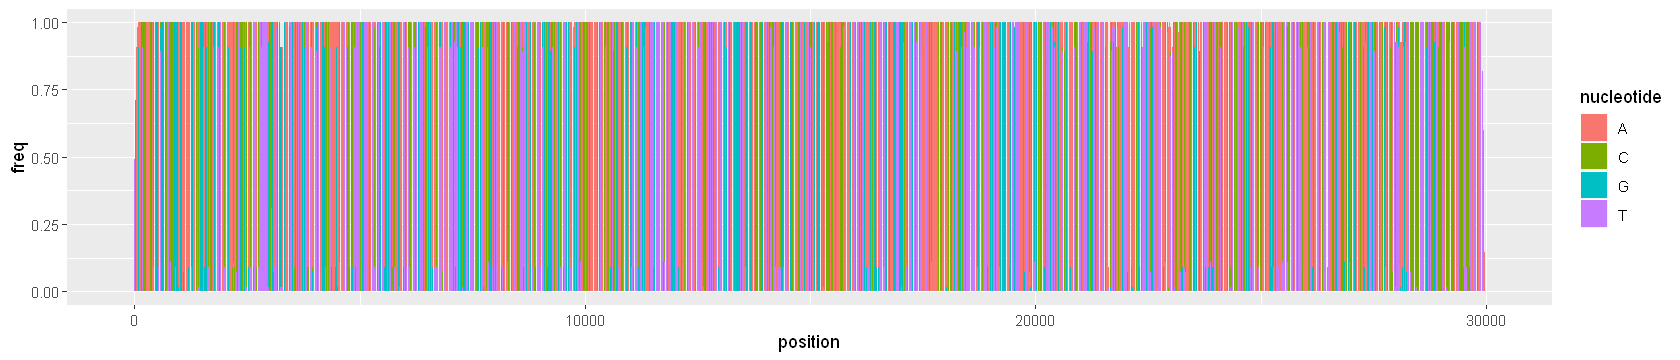

In [259]:
fasta_data <- read.fasta("common_msa_2.fasta")
l <- c(dna2char(fasta_data[1]))
for (i in 2:55) {
    l <- rbind(l, c(dna2char(fasta_data[i])))
}
string.set <- DNAStringSet(l)
options(repr.plot.width=14, repr.plot.height=3)
stacked.barplot(string.set)

Последовательности слишком большие, визуально различия почти не заметны.

Найдем позиции, по которым штаммы различаются сильнее всего. Будем использовать для оценки того, насколько последовательности в данной позиции различаются, следующую метрику: в каждой позиции возьмем число, равное максимальной частоте среди частот $A,C,G,T$ в ней. Затем найдем те позиции, в которых эта метрика минимальна.

In [260]:
consMatr <- consensusMatrix(string.set)[1:4,]
colmax <- apply(consMatr,2,max)

In [261]:
names(colmax) <- 1:length(colmax)

In [262]:
names(sort(colmax[which(colmax>0)])[1:50])

[1] "1"     "2"     "3"     "4"     "3080"  "3078"  "3079"  "4895"  "21622"
[10] "21623" "21624" "21625" "21626" "21627" "21628" "21630" "21633" "27717"
[19] "28023" "28024" "28025" "28204" "28205" "28206" "28303" "28304" "28351"
[28] "148"   "149"   "2741"  "2742"  "2743"  "3075"  "3076"  "3077"  "4896" 
[37] "4897"  "21581" "21582" "21629" "21631" "21632" "26482" "26483" "26484"
[46] "27421" "27422" "27423" "27424" "27425"

Построим диаграмму зависимости этой метрики от позиции:

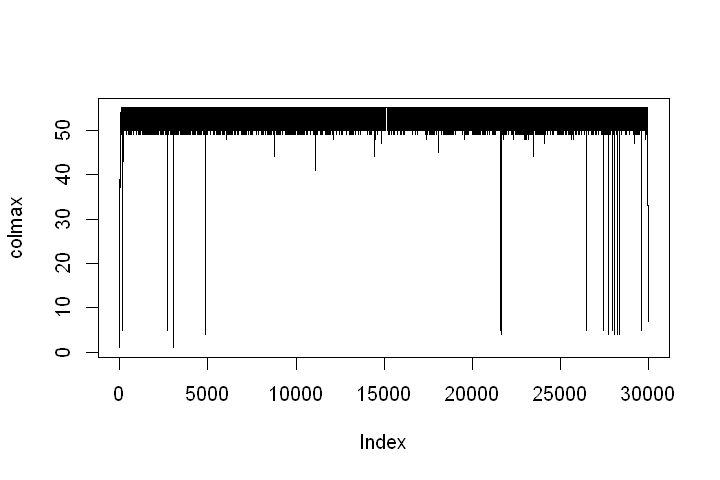

In [270]:
options(repr.plot.width=6, repr.plot.height=4)
plot(colmax,type='l')

Итог: как видим, больше всего отличий наблюдается на концах выровненных последовательностей. Однако, на самых концах отличия связаны с выравниванием, поэтому лучше брать позиции поближе к середине. Больше всего отличий, судя по виду графика, в промежутке от $26000$ позиции до $29000$.

Сайт [NCBI](https://www.ncbi.nlm.nih.gov/genbank/sars-cov-2-seqs/#nucleotide-sequences) позволяет определять белки, которым отвечают конкретные позиции в геноме. Например, полипротеин `1ab` и шиповидный белок, которые мы будем изучать далее, отвчают соответственно приблизительным (зависят от конкретного штамма) промежуткам $[260,21555]$ и $[21600,25390]$ (в геноме они идут почти сразу один за другим). В силу большого размера эти белки точно стоит сравнивать между собой. После шиповидного белка идут белки ("ORF3a protein", "ORF6 protein" и т.д.), отвечающие совсем коротким последовательностям, поэтому вряд ли их сравнение даст хороший результат (к тому же в отличие от полипротеина `1ab` и шиповидного белка эти которкие протеины могут у одних штаммов быть, а у других не быть); на гистограмме, судя по всему, наиболее сильные отличия возникли там, где заканчивается один белок и начинается другой из-за выравнивания. Вывод: если сравнивать штаммы по отрезкам геномов, лучше всего рассматривать именно полипротеин `1ab` и шиповидный белок в виду из размера.

### Воспроизведение исследования А. Панчина.

Напомню: в данной части исследования рассматриваются вирусы: `SARS Coronavirus MA15` (штамм JF292920), `RaTG13` (эти два взяты у летучих мышей в 2014 и 2013 годах соответственно), `RsSHC014-COV` и современный `COVID-19` (я рассмотрел штамм `MT019529`, один из самых ранних найденных в Ухани в декабре 2019 г.)

У них будем сравнивать шиповидный белок и полипротеин `1ab` (у некоторых вирусов он называется `1ab`, у других - `orf1ab`, но это разновидности одного и того же протеина. С шиповидном белком то же самое: есть названия `spike protein`, `surface glycoprotein`, `spike_glycoprotein_precursor`).

У искусственно созданного `SHC014-MA15`, согласно статье 2015 года, с вирусом `RsSHC014-COV` совпадает шиповидный белок, а с вирусом `SARS Coronavirus MA15` - полипротеин `1ab` (и, видимо, весь геном кроме шиповидного белка).

#### 4.2. Сравнение полипротеина 1ab.

Цель - показать, что полипротин `1ab` штамма `RaTG13` имеет гораздо большее сходство с соответствующим полипротеином у `COVID-19`, чем с `1ab` из коронавируса `MA15` и `RsSHC014`.

In [9]:
COVID_19.1ab <- read.fasta("MT019529_polyprotein_orf1ab.fasta")
RaTG13.1ab <- read.fasta("RaTG13_polyprotein_orf1ab.fasta")
MA15.1ab <- read.fasta("MA15_polyprotein_orf1ab.fasta")
RsSHC014.1ab <- read.fasta("RsSHC014_1ab.fasta")

In [10]:
string.set <- AAStringSet(c(toupper(aa2char(COVID_19.1ab)),
                     toupper(aa2char(RaTG13.1ab)),
                     toupper(aa2char(MA15.1ab)),
                     toupper(aa2char(RsSHC014.1ab))))
string.set

  A AAStringSet instance of length 4
    width seq                                               names               
[1]  7096 MESLVPGFNEKTHVQLSLPVLQV...SKGRLIIRENNRVVISSDVLVNN QHU36823.1 orf1ab...
[2]  7095 MESLVPGFNEKTHVQLSLPVLQV...SKGRLIIRENNRVVISSDVLVNN QHR63299.1 orf1ab...
[3]  7073 MESLVLGVNEKTHVQLSLPVLQV...EKGRLIIRENNRVVVSSDILVNN AEA10982.1 polypr...
[4]  7073 MESLVLGVNEKTHVQLSLPVLQV...EKGRLIIRESNKVVVSSDILVNI AGZ48805.1 non-st...

Выравнивание:

In [11]:
string.set <- AAStringSet(msa(string.set))
string.set

use default substitution matrix


  A AAStringSet instance of length 4
    width seq                                               names               
[1]  7100 MESLVPGFNEKTHVQLSLPVLQV...SKGRLIIRENNRVVISSDVLVNN QHU36823.1 orf1ab...
[2]  7100 MESLVPGFNEKTHVQLSLPVLQV...SKGRLIIRENNRVVISSDVLVNN QHR63299.1 orf1ab...
[3]  7100 MESLVLGVNEKTHVQLSLPVLQV...EKGRLIIRENNRVVVSSDILVNN AEA10982.1 polypr...
[4]  7100 MESLVLGVNEKTHVQLSLPVLQV...EKGRLIIRESNKVVVSSDILVNI AGZ48805.1 non-st...

In [15]:
"Сходство полипротеина 1ab для COVID-19 и RaTG13:"
element_wise.compare(string.set[1],string.set[2])
"Сходство полипротеина 1ab для COVID-19 и MA15:"
element_wise.compare(string.set[1],string.set[3])
"Сходство полипротеина 1ab для COVID-19 и RsSHC014:"
element_wise.compare(string.set[1],string.set[4])
"Сходство полипротеина 1ab для RaTG13 и MA15:"
element_wise.compare(string.set[2],string.set[3])
"Сходство полипротеина 1ab для MA15 и RsSHC014:"
element_wise.compare(string.set[2],string.set[4])
"Сходство полипротеина 1ab для MA15 и RsSHC014:"
element_wise.compare(string.set[3],string.set[4])

[1] "Сходство полипротеина 1ab для COVID-19 и RaTG13:"

[1] 0.9852113

[1] "Сходство полипротеина 1ab для COVID-19 и MA15:"

[1] 0.8604225

[1] "Сходство полипротеина 1ab для COVID-19 и RsSHC014:"

[1] 0.8605634

[1] "Сходство полипротеина 1ab для RaTG13 и MA15:"

[1] 0.8595775

[1] "Сходство полипротеина 1ab для MA15 и RsSHC014:"

[1] 0.8592958

[1] "Сходство полипротеина 1ab для MA15 и RsSHC014:"

[1] 0.984507

Сходство действительно примерно такое, как заявлено в статье А.Панчина (числа отличаются в пределах $0.01\%$, но, видимо, я и А. Панчин просто рассмотрели разные штаммы `COVID-19`, которые многочисленны, но очень похожи между собой с точки зрения конкретных протеинов, в т.ч. `1ab`.)

Таким образом, ген, отвечающий протеину `1ab`, у вируса `SARS Coronavirus MA15` (а значит, и у созданного на его основе вируса `SHC014-MA15`) гораздо сильнее отличается от современного `COVID-19`, чем у `RsSHC014-COV`, взятого у летучих мышей не позднее 2014 года. А вот у `RaTG13` этот белок, в отличие от двух остальных рассмотренных, очень похож на тот же белок современного коронавируса.

#### 4.3. Сравнение шиповидного белка.

Теперь воспроизведем аналогичный анализ для шиповидного белка.

In [11]:
COVID_19.spike <- read.fasta("MT019529_surface_glycoprotein.fasta")
RaTG13.spike <- read.fasta("RaTG13_spike_glycoprotein.fasta")
MA15.spike <- read.fasta("MA15-COV_spike_glycoprotein_precursor.fasta")
RsSHC014.spike <- read.fasta("RsSHC014_spike_protein.fasta")

In [12]:
string.set <- AAStringSet(c(toupper(aa2char(COVID_19.spike)),
                     toupper(aa2char(RaTG13.spike)),
                     toupper(aa2char(MA15.spike)),
                     toupper(aa2char(RsSHC014.spike))))
string.set

  A AAStringSet instance of length 4
    width seq                                               names               
[1]  1273 MFVFLVLLPLVSSQCVNLTTRTQ...GSCCKFDEDDSEPVLKGVKLHYT QHU36824.1 surfac...
[2]  1269 MFVFLVLLPLVSSQCVNLTTRTQ...GSCCKFDEDDSEPVLKGVKLHYT QHR63300.2 spike ...
[3]  1255 MFIFLLFLTLTSGSDLDRCTTFD...GSCCKFDEDDSEPVLKGVKLHYT AEA10983.1 spike ...
[4]  1256 MKLLVLVFATLVSSYTIEKCLDF...GSCCKFDEDDSEPVLKGVKLHYT AGZ48806.1 spike ...

In [13]:
string.set <- AAStringSet(msa(string.set))
string.set

use default substitution matrix


  A AAStringSet instance of length 4
    width seq                                               names               
[1]  1278 -MFIFLLFLTLTSGSDLDRCTTF...GSCCKFDEDDSEPVLKGVKLHYT AEA10983.1 spike ...
[2]  1278 MKLLVLVFATLVSSYTIEKCLDF...GSCCKFDEDDSEPVLKGVKLHYT AGZ48806.1 spike ...
[3]  1278 -MFVFLVLLPLVSS----QCVNL...GSCCKFDEDDSEPVLKGVKLHYT QHU36824.1 surfac...
[4]  1278 -MFVFLVLLPLVSS----QCVNL...GSCCKFDEDDSEPVLKGVKLHYT QHR63300.2 spike ...

In [14]:
"Сходство шиповидного белка для COVID-19 и RaTG13:"
element_wise.compare(string.set[1],string.set[2])
"Сходство шиповидного белка для COVID-19 и MA15:"
element_wise.compare(string.set[1],string.set[3])
"Сходство шиповидного белка для COVID-19 и RsSHC014:"
element_wise.compare(string.set[1],string.set[4])
"Сходство шиповидного белка для RaTG13 и MA15:"
element_wise.compare(string.set[2],string.set[3])
"Сходство шиповидного белка для MA15 и RsSHC014:"
element_wise.compare(string.set[2],string.set[4])
"Сходство шиповидного белка для MA15 и RsSHC014:"
element_wise.compare(string.set[3],string.set[4])

[1] "Сходство шиповидного белка для COVID-19 и RaTG13:"

[1] 0.900626

[1] "Сходство шиповидного белка для COVID-19 и MA15:"

[1] 0.756651

[1] "Сходство шиповидного белка для COVID-19 и RsSHC014:"

[1] 0.7644757

[1] "Сходство шиповидного белка для RaTG13 и MA15:"

[1] 0.7668232

[1] "Сходство шиповидного белка для MA15 и RsSHC014:"

[1] 0.7707355

[1] "Сходство шиповидного белка для MA15 и RsSHC014:"

[1] 0.9741784

Вывод: расчеты А. Панчина подтвердились, сходство шиповидного белка вирусов `MA15` и `RsSHC014` (следовательно, и `SHC014-MA15`) с современным коронавирусом ($75.66\%$, $76.44\%$ соответственно в данном эксперименте) почти такое же, как он пишет ($75.88\%$, $77.31\%$), разница связана с выбором конкретных штаммов. Сходство `MA15` и `RsSHC014` в данном эксперименте ($97.41\%$) и у А. Панчина ($97.41\%$) также совпало, даже с точностью до сотых процента.

### Мое добавление к исследованию: А. Панчина.

#### 4.4. Сравнение полных геномов.

In [49]:
COVID_19 <- read.fasta("MT019529_2019_12_23_China_Wuhan.fasta")
RaTG13 <- read.fasta("RaTG13.fasta")
MA15 <- read.fasta("MA15-COV.fasta")
RsSHC014 <- read.fasta("RsSHC014.fasta")

In [50]:
string.set <- DNAStringSet(c(toupper(dna2char(COVID_19)),
                     toupper(dna2char(RaTG13)),
                     toupper(dna2char(MA15)),
                     toupper(dna2char(RsSHC014))))
string.set

  A DNAStringSet instance of length 4
    width seq                                               names               
[1] 29899 ATTAAAGGTTTATACCTTCCCAG...AAAAAAAAAAAAAAAAAAAAAAA MT019529.1 Severe...
[2] 29855 CTTTCCAGGTAACAAACCAACGA...GACAAAAAAAAAAAAAAAAAAAA MN996532.1 Bat co...
[3] 29646 CGATCTCTTGTAGATCTGTTCTC...TGTGTAAAATTAATTTTAGTAGT JF292920.1 SARS c...
[4] 29787 ATATTAGGTTTTTACCTACCCAG...ATGACAAAAAAAAAAAAAAAAAA KC881005.1 Bat SA...

In [51]:
string.set <- DNAStringSet(msa(string.set))
string.set

use default substitution matrix


  A DNAStringSet instance of length 4
    width seq                                               names               
[1] 29957 -----------------------...----------------------- JF292920.1 SARS c...
[2] 29957 ATATTAGGTTTTTACCTACCCAG...AAAAAAAAAAAA----------- KC881005.1 Bat SA...
[3] 29957 ATTAAAGGTTTATACCTTCCCAG...AAAAAAAAAAAAAAAAAAAAAAA MT019529.1 Severe...
[4] 29957 ---------------CTTTCCAG...AAAAAAAAAAAAAA--------- MN996532.1 Bat co...

In [52]:
"Сходство геномов COVID-19 и RaTG13:"
element_wise.compare(string.set[1],string.set[2])
"Сходство геномов COVID-19 и MA15:"
element_wise.compare(string.set[1],string.set[3])
"Сходство геномов COVID-19 и RsSHC014:"
element_wise.compare(string.set[1],string.set[4])
"Сходство геномов RaTG13 и MA15:"
element_wise.compare(string.set[2],string.set[3])
"Сходство геномов MA15 и RsSHC014:"
element_wise.compare(string.set[2],string.set[4])
"Сходство геномов MA15 и RsSHC014:"
element_wise.compare(string.set[3],string.set[4])

[1] "Сходство геномов COVID-19 и RaTG13:"

[1] 0.9483259

[1] "Сходство геномов COVID-19 и MA15:"

[1] 0.7859933

[1] "Сходство геномов COVID-19 и RsSHC014:"

[1] 0.7853924

[1] "Сходство геномов RaTG13 и MA15:"

[1] 0.7906332

[1] "Сходство геномов MA15 и RsSHC014:"

[1] 0.7898989

[1] "Сходство геномов MA15 и RsSHC014:"

[1] 0.9603432

In [ ]:
#dist.dna(as.DNAbin(DNAStringSet(string.set)))
#base.freq(as.DNAbin(DNAStringSet(string.set)))

Теперь произведем визуальное сравнение:

In [72]:
names(string.set) <- c("MA15","RsSHC014","COVID-19","RaTG13")

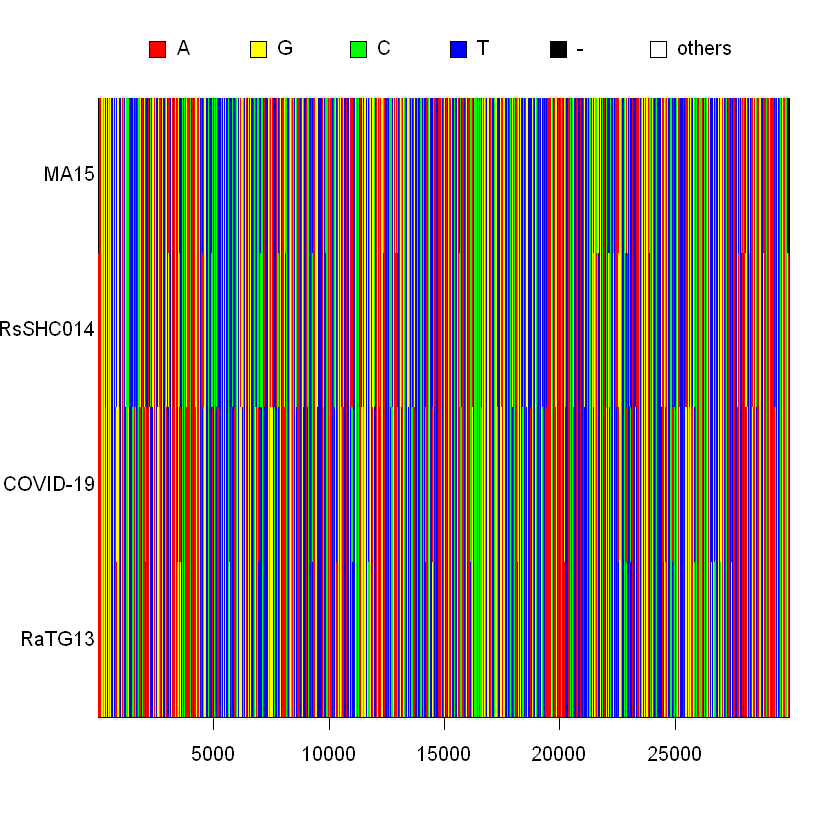

In [74]:
image(as.DNAbin(DNAStringSet(string.set)))

Результат: `COVID-19` отличается и от `MA15`, и от `RsSHC014` гораздо сильнее, чем от `RaTG13` (а с последним он очень схож). `COVID-19` похож на `RaTG13`, `RsSHC014` и `MA15`, но между этими парами сильное отличие.

#### 4.5. Филогенетическое дерево.

Теперь построим филогенетическое дерево по $55$ штаммам, включающим в себя $1$ штамм `RaTG13`, $1$ штамм `RsSHC014`, $4$ штамма `MA15` и $49$ штаммов `COVID-19`, которые были взяты из разных стран за разные месяцы, начиная с конца декабря $2019$ года. Данные, как и выше, были заранее выровнены с помощью онлайн ресурса.

Для удобства визуализации дерева вершины будем помечать численными индексами и отдельно выпишем их расшифровку.

55 DNA sequences in binary format stored in a matrix.

All sequences of same length: 29970 

Labels:
MN996532.1 Bat coronavirus RaTG13, complete genome
MT233522.1 Severe acute respiratory syndrome coronavirus 2 i...
MT007544.1 Severe acute respiratory syndrome coronavirus 2 i...
MT308704.1 Severe acute respiratory syndrome coronavirus 2 i...
MT258383.1 Severe acute respiratory syndrome coronavirus 2 i...
MT039890.1 Severe acute respiratory syndrome coronavirus 2 i...
...

Base composition:
    a     c     g     t 
0.298 0.185 0.197 0.320 
(Total: 1.65 Mb)

[[1]]
[1] "MN996532.1 Bat coronavirus RaTG13, complete genome"

[[2]]
[1] "MT233522.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/ESP/Valencia7/2020, complete genome"

[[3]]
[1] "MT007544.1 Severe acute respiratory syndrome coronavirus 2 isolate Australia/VIC01/2020, complete genome"

[[4]]
[1] "MT308704.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/UNC_200189/2020, complete genome"

[[5]]
[1] "MT258383.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/CZB-RR057-015/2020, complete genome"

[[6]]
[1] "MT039890.1 Severe acute respiratory syndrome coronavirus 2 isolate SNU01, complete genome"

[[7]]
[1] "MT293212.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USAWA-UW449/2020, complete genome"

[[8]]
[1] "MT281577.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/CHN/Fuyang_FY002/2020, complete genome"

[[9]]
[1] "MT019529.1 Severe acute respiratory syndrome coronavirus 2 isolate BetaCoV/Wuhan/IPBCAMS-WH-01/2019, complete genome"

[[10]]
[1] "LC529905.1 Severe acute respiratory syndrome coronavirus 2 TKYE6182_2020 RNA, complete genome"

[[11]]
[1] "MT291828.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/CHN/Wuhan_IME-WH03/2019, complete genome"

[[12]]
[1] "MT019531.1 Severe acute respiratory syndrome coronavirus 2 isolate BetaCoV/Wuhan/IPBCAMS-WH-03/2019, complete genome"

[[13]]
[1] "MT291830.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/CHN/Wuhan_IME-WH05/2019, complete genome"

[[14]]
[1] "MN908947.3 Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome"

[[15]]
[1] "MT263436.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/WA-UW356/2020, complete genome"

[[16]]
[1] "MT262993.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-Cov-2/human/PAK/Manga1/2020, complete genome"

[[17]]
[1] "MT012098.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/IND/29/2020, complete genome"

[[18]]
[1] "MT276598.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/ISR/ISR_IT0320/2020, complete genome"

[[19]]
[1] "MT263074.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/PER/Peru-10/2020, complete genome"

[[20]]
[1] "MT263439.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/WA-UW359/2020, complete genome"

[[21]]
[1] "MT292570.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/ESP/Valencia17/2020, complete genome"

[[22]]
[1] "MT233519.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/ESP/Valencia5/2020, complete genome"

[[23]]
[1] "MN988713.1 Severe acute respiratory syndrome coronavirus 2 isolate 2019-nCoV/USA-IL1/2020, complete genome"

[[24]]
[1] "MT246452.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/WA-UW195/2020, complete genome"

[[25]]
[1] "MT246464.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/WA-UW207/2020, complete genome"

[[26]]
[1] "MT259254.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/WA-UW262/2020, complete genome"

[[27]]
[1] "MT304485.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/NH_0008/2020, complete genome"

[[28]]
[1] "MT276323.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/RI_0520/2020, complete genome"

[[29]]
[1] "MT049951.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/CHN/Yunnan-01/2020, complete genome"

[[30]]
[1] "MT291832.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/CHN/Wuhan_IME-BJ02/2020, complete genome"

[[31]]
[1] "MN985325.1 Severe acute respiratory syndrome coronavirus 2 isolate 2019-nCoV/USA-WA1/2020, complete genome"

[[32]]
[1] "MN938384.1 Severe acute respiratory sy

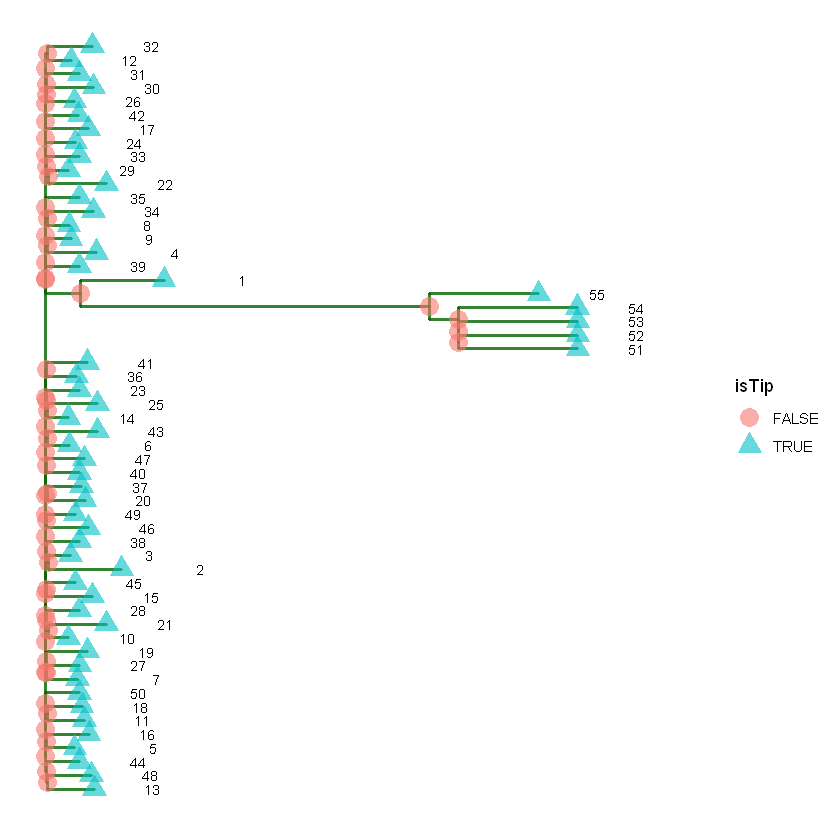

In [194]:
fasta_data <- as.matrix(read.fasta("common_msa_2.fasta"))
fasta_data
as.list(labels(fasta_data))
rownames(fasta_data) <- 1:55
phy.data <- as.phyDat(as.matrix(fasta_data))
tree <- nj(dist.logDet(phy.data))
ggtree(tree, lwd = 1, color = "darkgreen", alpha = 0.8, right = TRUE) +
  geom_tiplab(size = 3, angle = 0, offset = 0.05, hjust = 3) +
  geom_point(aes(shape = isTip, color = isTip), size = 5, alpha = 0.6)

Снова видим, что `RaTG13` (индекс $1$ ) гораздо ближе к штаммам `COVID-19`, чем `MA15` (индексы $51-54$ ) и `RsSHC014`(индекс $55$ ), а также то, что штаммы `COVID-19` похожи между собой и сильно ветвятся. Полученное дерево вряд ли хорошо показывает генеалогическое происхождение видов, но зато отображает степень их сходства. Также можно, например заметить, что из рассмотренных штаммов `COVID-19` сильнее всех отличаются от других $2$, $21$, $22$, которые были найдены в Валенсии, т.е. в Испании вирус в своем развитии уходит от других видов.

Наконец, наглядно покажем сходство штаммов `COVID-19` между собой.

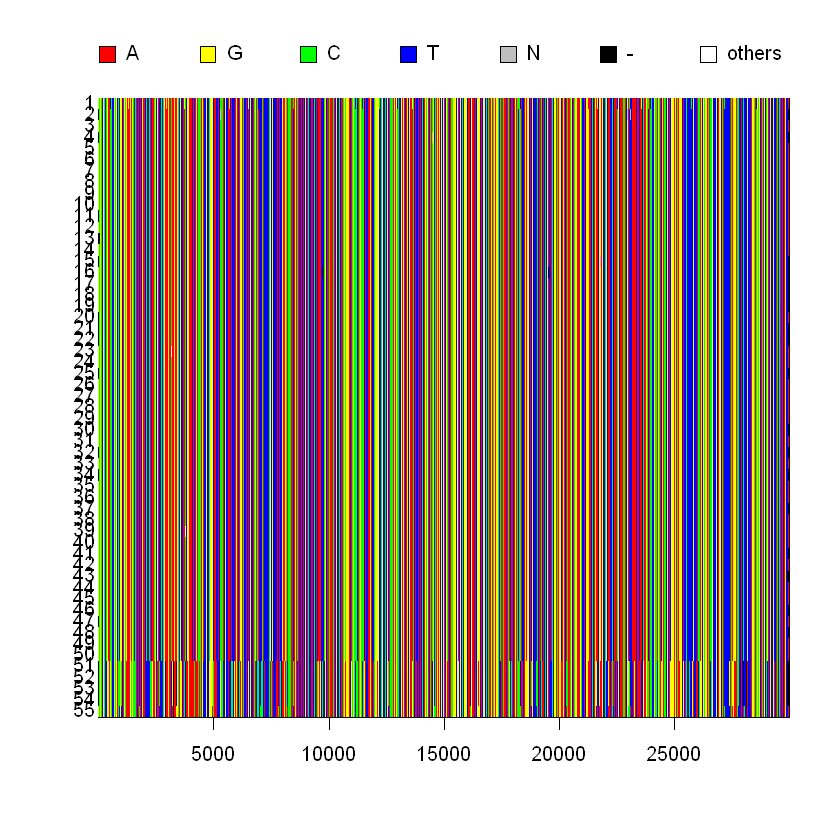

In [283]:
image(fasta_data)

Как видим, современные штаммы `COVID-19` (индексы $2-50$) действительно очень между собой похожи, а также (хотя и в меньшей степени) похожи на `RaTG13`(индекс $1$).

## Вывод:

1. Из рассмотренных геномов `COVID-19` наиболее похож на `RaTG13`. Он сильно отличается и от `MA15`, и от `RsSHC014`, и от искусственно созданного их "гибрида" - `SHC014-MA15`.

2. Поэтому `COVID-19`, скорее всего, мутировал из вирусов летучих мышей, встречающихся в естесственных условиях (вероятно, из `RaTG13` или его родственника). У него было много времени для этого (более 5 лет), поэтому гипотеза о его лабораторном происхождении (необязательно от `SHC014-MA15`) с достаточно большой степенью уверенности отвергается.